# 3.7 "찐" Multi-Agent System (feat. create_react_agent)

- 도구들을 활용하는 에이전트들이 협업하는 과정을 구현합니다

In [11]:
from dotenv import load_dotenv

load_dotenv(dotenv_path="../.env")

True

In [12]:
from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama

# llm = ChatOpenAI(model="gpt-4o-mini")
llm = ChatOllama(model="llama3.1")

In [ ]:
from langgraph.graph import MessagesState
from langgraph.types import Command
from typing import Literal
from langchain.agents import create_agent
# from langchain_community.agent_toolkits.polygon.toolkit import PolygonToolkit
from langchain_community.utilities.polygon import PolygonAPIWrapper
from langchain_community.tools import YahooFinanceNewsTool, PolygonTickerNews, PolygonFinancials, PolygonLastQuote
from langchain_core.messages import HumanMessage


def market_research(state: MessagesState) -> Command[Literal["supervisor"]]:
    """
    시장 조사 node입니다. 주어진 state를 기반으로 시장 조사 에이전트를 호출하고,
    결과를 supervisor node로 전달합니다.
    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체입니다.
    Returns:
        Command: supervisor node로 이동하기 위한 명령을 반환합니다.
    """
    print("*** market_research ***")
    polygon_api_wrapper = PolygonAPIWrapper()

    # polygon_toolkit = PolygonToolkit.from_polygon_api_wrapper(polygon_api_wrapper=polygon_api_wrapper)
    # polygon_tools = polygon_toolkit.get_tools()
    # market_research_tools = [YahooFinanceNewsTool()] + polygon_tools

    market_research_tools = [
        YahooFinanceNewsTool(),
        PolygonTickerNews(api_wrapper=polygon_api_wrapper),
        # PolygonFinancials(api_wrapper=polygon_api_wrapper),
        # PolygonLastQuote(api_wrapper=polygon_api_wrapper),
    ]

    market_research_agent = create_agent(
        model=llm,
        tools=market_research_tools,
        system_prompt="너는 시장 조사 전문가야. 의견 빼고 사실만 제공해 줘"
    )
    result = market_research_agent.invoke(state)
    return Command(
        goto="supervisor",
        update={"messages": [HumanMessage(content=result["messages"][-1].content, name="market_research")]},
    )

In [14]:
import yfinance as yf
from langchain_core.tools import tool

@tool
def get_stock_price(ticker: str) -> dict:
    """개별 종목에 대한 지난 1달 주가 데이터를 반환합니다."""
    stock_price = yf.download(tickers=ticker, period="1mo").to_dict()
    return stock_price

def stock_research(state: MessagesState) -> Command[Literal["supervisor"]]:
    """
    주식 조사 node입니다. 주어진 State를 기반으로 주식 조사 에이전트를 호출하고,
    결과를 supervisor node로 전달합니다.
    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체입니다.
    Returns:
        Command: supervisor node로 이동하기 위한 명령을 반환합니다.
    """
    print("*** stock_research ***")
    stock_research_tools = [get_stock_price]
    stock_research_agent = create_agent(
        model=llm,
        tools=stock_research_tools,
        system_prompt="너는 주식 조사 전문가야. 의견 빼고 사실만 제공해 줘"
    )
    result = stock_research_agent.invoke(state)
    return Command(
        goto="supervisor",
        update={"messages": [HumanMessage(content=result["messages"][-1].content, name="stock_research")]},
    )


In [15]:
@tool
def get_company_infos(ticker: str) -> dict:
    """개별 종목에 대한 재무 정보와 공시 자료를 반환합니다."""
    company_info = yf.Ticker(ticker)
    financial_info = company_info.get_financials()
    sec_filings = company_info.get_sec_filings()
    return {
        "financial_info": financial_info,
        "sec_filings": sec_filings,
    }

def company_research(state: MessagesState) -> Command[Literal["supervisor"]]:
    """
    회사 조사 node입니다. 주어진 State를 기반으로 회사 조사 에이전트를 호출하고,
    결과를 supervisor node로 전달합니다.
    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체입니다.
    Returns:
        Command: supervisor node로 이동하기 위한 명령을 반환합니다.
    """
    print("*** company_research ***")
    company_research_tools = [get_company_infos]
    company_research_agent = create_agent(
        model=llm,
        tools=company_research_tools,
        system_prompt="너는 기업 조사 전문가야. 의견 빼고 사실만 제공해 줘"
    )
    result = company_research_agent.invoke(state)
    return Command(
        goto="supervisor",
        update={"messages": [HumanMessage(content=result["messages"][-1].content, name="company_research")]},
    )

In [16]:
from langchain_core.prompts import PromptTemplate

def analyst(state: MessagesState) -> MessagesState:
    """
    분석가 node입니다. 주어진 State를 기반으로 분석가 체인을 호출하고,
    결과 메시지를 반환합니다.
    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체입니다.
    Returns:
        dict: 분석 결과 메시지를 포함하는 딕셔너리를 반환합니다.
    """
    print("*** analyst ***")
    analyst_prompt = PromptTemplate.from_template(
        """너는 주식 시장 전문가야. 아래 정보를 참고해서 살지, 팔지, 보유할지 알려줘
        information: {messages}""")
    analyst_chain = analyst_prompt | llm
    result = analyst_chain.invoke({"messages": state["messages"][1:]})
    return {"messages": [result]}

- `supervisor`가 회사의 매니저와 유사한 역할을 하면서, 각 에이전트들의 결과를 종합하여 작업이 끝났는지 판단합니다

In [17]:
from typing import TypedDict

members = ["market_research", "stock_research", "company_research"]
options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH"""
    next: Literal[*options]


def supervisor(state: MessagesState) -> Command[Literal[*members, "analyst"]]:
    """
    supervisor node입니다. 주어진 State를 기반으로 각 worker의 결과를 종합하고,
    다음에 수행할 worker를 결정합니다. 모든 작업이 완료되면 analyst node로 이동합니다.
    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체입니다.
    Returns:
        Command: 다음에 수행할 worker 또는 analyst node로 이동하기 위한 명령을 반환합니다.
    """
    print("*** supervisor ***")
    messages = [{
        "role": "system",
        "content": system_prompt,
    }] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = "analyst"
    return Command(goto=goto)

- `node`를 추가하고 `edge`로 연결합니다

In [18]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(MessagesState)

workflow.add_node(market_research)
workflow.add_node(stock_research)
workflow.add_node(company_research)
workflow.add_node(analyst)
workflow.add_node(supervisor)

workflow.add_edge(START, "supervisor")
workflow.add_edge("analyst", END)

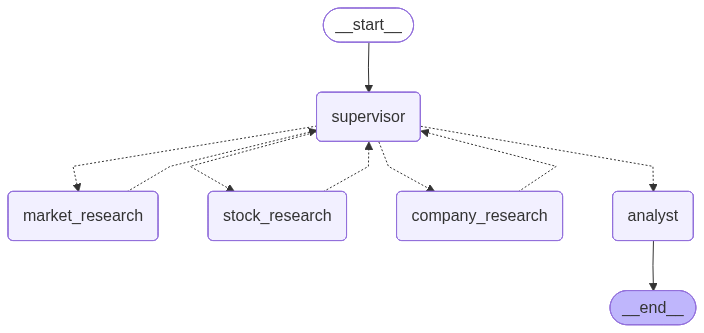

In [19]:
from IPython.display import display, Image

graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
query = "엔비디아(NVDA)에 지금 투자하는게 좋을까?"

for response in graph.stream({"messages": [("user", query)]}, stream_mode="values"):
    response["messages"][-1].pretty_print()

================================ Human Message =================================

엔비디아(NVDA)에 지금 투자하는게 좋을까?
*** supervisor ***
*** market_research ***
================================ Human Message =================================
Name: market_research

Neither of these articles provides factual information about NVIDIA's market value or financial performance. They both discuss opinions from analysts and investors regarding NVIDIA's potential for future growth.

However, I can provide some general facts about NVIDIA:

NVIDIA is a technology company that specializes in graphics processing units (GPUs) and high-performance computing hardware. The company was founded in 1993 and is headquartered in Santa Clara, California.
NVIDIA's market value has fluctuated over time, but as of my knowledge cutoff date (December 2023), it had a market capitalization of around $700 billion.
NVIDIA's revenue has been growing steadily due to increasing demand for its products, particularly in the areas of

[*********************100%***********************]  1 of 1 completed


================================ Human Message =================================
Name: stock_research

기록된 데이터를 기반으로 엔비디아(NVDA)의 현재 가격은 약 $190.53입니다. 그러나 이 가격은 기록된 마지막 거래 날짜인 2025년 12월 26일의 가격이므로, 현재 가격을 정확하게 알 수 없습니다. NVDA의 주가 변동성을 고려하면, 현재 가격에 대한 신뢰할만한 정보를 제공할 수 없습니다.

NVDA의 역사적 가격 데이터를 분석하면, 엔비디아의 주가는 시간과 함께 상승한 경향이 있습니다. 그러나 이 주가 상승은 기록된 마지막 거래 날짜인 2025년 12월 26일까지 이어지지 않았습니다.

현재 NVDA에 투자하는 것이 좋을까요? 여전히 투자하는 것이 좋은지 여부는 개인의 기호와 수익 목표에 따라 달라집니다. 엔비디아는 기술 회사로, 주가 변동성이 높으며 종종 급격한 상승과 하락이 발생합니다.

따라서 NVDA에 투자하려면, 시장 상황을 꼼꼼하게 분석하고 개인의 기호와 수익 목표를 고려하는 것이 중요합니다. 또한 엔비디아의 역사적 가격 데이터를 참조하면, 엔비디아가 시간과 함께 상승한 경향이 있는 것으로 나타났습니다.

만약에 NVDA의 현재 가격을 정확하게 알기 원한다면 다른 방법으로는 주식 거래소에서 정보를 직접 확인하거나 전문가의 συμβ고를 받는 방법등이 있습니다.
*** supervisor ***
*** stock_research ***


[*********************100%***********************]  1 of 1 completed


================================ Human Message =================================
Name: stock_research

현재 NVDA의 가격은 약 $190.53입니다. 그러나 이 가격은 기록된 마지막 거래 날짜인 2025년 12월 26일의 가격이므로, 현재 가격을 정확하게 알 수 없습니다.

NVDA의 주가는 시간과 함께 상승한 경향이 있습니다. 그러나 주가 변동성이 높으며 종종 급격한 상승과 하락이 발생합니다.

현재 NVDA에 투자하는 것이 좋을까요? 여전히 투자하는 것이 좋은지 여부는 개인의 기호와 수익 목표에 따라 달라집니다.
*** supervisor ***
*** stock_research ***


[*********************100%***********************]  1 of 1 completed


================================ Human Message =================================
Name: stock_research

현재 NVDA의 가격은 약 $190.53입니다.然而, 이 가격은 기록된 마지막 거래 날짜인 2025년 12월 26일의 가격이므로, 현재 가격을 정확하게 알 수 없습니다.

NVDA의 주가 변동성을 고려하면, 현재 가격에 대한 신뢰할만한 정보를 제공할 수 없습니다.

엔비디아는 기술 회사로, 주가 변동성이 높으며 종종 급격한 상승과 하락이 발생합니다. 따라서 NVDA에 투자하려면, 시장 상황을 꼼꼼하게 분석하고 개인의 기호와 수익 목표를 고려하는 것이 중요합니다.

현재 NVDA에 투자하는 것이 좋을까요? 여전히 투자하는 것이 좋은지 여부는 개인의 기호와 수익 목표에 따라 달라집니다.
*** supervisor ***
*** market_research ***
